In [26]:
from __future__ import print_function
from PIL import Image
import os
import os.path
import errno
import numpy as np
import sys
if sys.version_info[0] == 2:
    import cPickle as pickle
else:
    import pickle

import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity


class Semeion(data.Dataset):
    """`SEMEION <http://archive.ics.uci.edu/ml/datasets/semeion+handwritten+digit>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``semeion.py`` exists.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    url = "http://archive.ics.uci.edu/ml/machine-learning-databases/semeion/semeion.data"
    filename = "semeion.data"
    md5_checksum = 'cb545d371d2ce14ec121470795a77432'

    def __init__(self, root, transform=None, target_transform=None, download=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        self.data = []
        self.labels = []
        fp = os.path.join(root, self.filename)
        data = np.loadtxt(fp)
        # convert value to 8 bit unsigned integer
        # color (white #255) the pixels
        self.data = (data[:, :256] * 255).astype('uint8')
        self.data = np.reshape(self.data, (-1, 16, 16))
        self.labels = data[:, 256:]

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.labels[index]
    
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img, mode='L')
    
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        
        return img, target

    def __len__(self):
        return len(self.data)

    def _check_integrity(self):
        root = self.root
        fpath = os.path.join(root, self.filename)
        if not check_integrity(fpath, self.md5_checksum):
            return False
        return True

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        root = self.root
        download_url(self.url, root, self.filename, self.md5_checksum)

In [27]:
import torch
import random

class SubsetSampler(object):

    def __init__(self, subset):
        self.subset = subset

    def __iter__(self):
        return iter(self.subset)

    def __len__(self):
        return len(self.subset)


class SemeionSampler(object):

    def __init__(self, data_source, train_share=0.8):

        # Generate a list of indizes reaching from 0 ... len(data_source)-1
        idxList = list(range(0,len(data_source)))

        # Ensure that list is sorted randomly
        random.shuffle(idxList)

        # Split dataset random shares of train and test data
        numberOfTrainSamples = int(len(data_source) / (1 / train_share))
        
        self.train_samples = idxList[:numberOfTrainSamples]
        self.test_samples = idxList[numberOfTrainSamples:]


    def trainSampler(self):
        return SubsetSampler(self.train_samples)

    def testSampler(self):
        return SubsetSampler(self.test_samples)

In [28]:
import numpy as np
import torch

# Converts the 1-channel image into a 3-channel mage
class ExpandTo3D(object):

    def __call__(self, image):

        width = image.size()[1]
        height = image.size()[2]

        return image.expand(3,width,height)


# Transform 10-dimensional label data into 1-dimension
# Example: 0 0 1 0 0 0 0 0 0 0 => 2
class TransformLabel(object):

    def __call__(self, label):

        idx = np.where(label==1)[0][0]

        return idx


In [30]:
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torchvision.datasets
import torchvision.models as models


transformsData = transforms.Compose([transforms.Scale(250), transforms.ToTensor(), ExpandTo3D()] )
transformsTarget = transforms.Compose([TransformLabel()])

dataset = Semeion(root='./data', download=True, transform=transformsData, target_transform=transformsTarget)

sampler = SemeionSampler(dataset)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=20, sampler=sampler.trainSampler(), num_workers=2 )
testloader = torch.utils.data.DataLoader(dataset, batch_size=20, sampler=sampler.testSampler(), num_workers=2)

net = models.alexnet(num_classes=10)
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

print("Start training")
for epoch in range(300):
    
    running_loss = 0.0
    for data in trainloader:
        
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.cuda())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


    print(loss.data[0])

    correct = 0
    total = 0
    
    for data in testloader:
  
        images, labels = data
        outputs = net(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum()
        
    print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))

print('Finished Training')


Files already downloaded and verified
Start training
2.304201364517212
Accuracy of the network on the test images: 8.463950 %
2.304401159286499
Accuracy of the network on the test images: 8.150470 %
2.3018596172332764
Accuracy of the network on the test images: 8.777429 %
2.3014156818389893
Accuracy of the network on the test images: 8.777429 %
2.301117181777954
Accuracy of the network on the test images: 8.777429 %
2.2993617057800293
Accuracy of the network on the test images: 10.031348 %
2.2980246543884277
Accuracy of the network on the test images: 9.404389 %
2.2977840900421143
Accuracy of the network on the test images: 11.912226 %
2.297706365585327
Accuracy of the network on the test images: 12.225705 %
2.2934682369232178
Accuracy of the network on the test images: 12.852665 %
2.2922675609588623
Accuracy of the network on the test images: 13.479624 %
2.2870707511901855
Accuracy of the network on the test images: 12.852665 %
2.274027109146118
Accuracy of the network on the test ima

Accuracy of the network on the test images: 99.059561 %
0.0004837853484787047
Accuracy of the network on the test images: 99.059561 %
0.008213043212890625
Accuracy of the network on the test images: 98.746082 %
0.0009070805390365422
Accuracy of the network on the test images: 97.805643 %
0.24742624163627625
Accuracy of the network on the test images: 98.746082 %
0.0007929801940917969
Accuracy of the network on the test images: 98.119122 %
0.0035092830657958984
Accuracy of the network on the test images: 98.119122 %
0.0035247120540589094
Accuracy of the network on the test images: 98.432602 %
4.3596541217993945e-05
Accuracy of the network on the test images: 98.746082 %
5.0067901611328125e-05
Accuracy of the network on the test images: 97.492163 %
0.0019478116882964969
Accuracy of the network on the test images: 97.492163 %
0.0027373176999390125
Accuracy of the network on the test images: 98.119122 %
0.0013425691286101937
Accuracy of the network on the test images: 97.492163 %
0.0004564

Process Process-943:
Process Process-944:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes(

KeyboardInterrupt: 

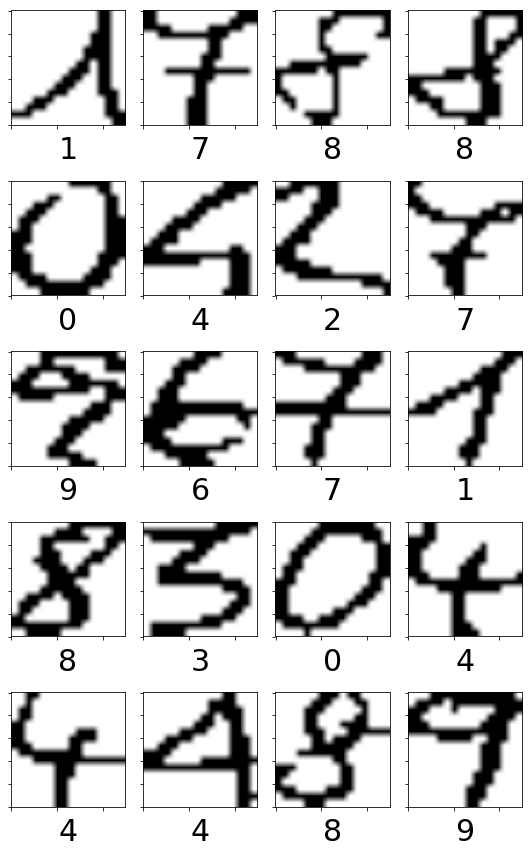

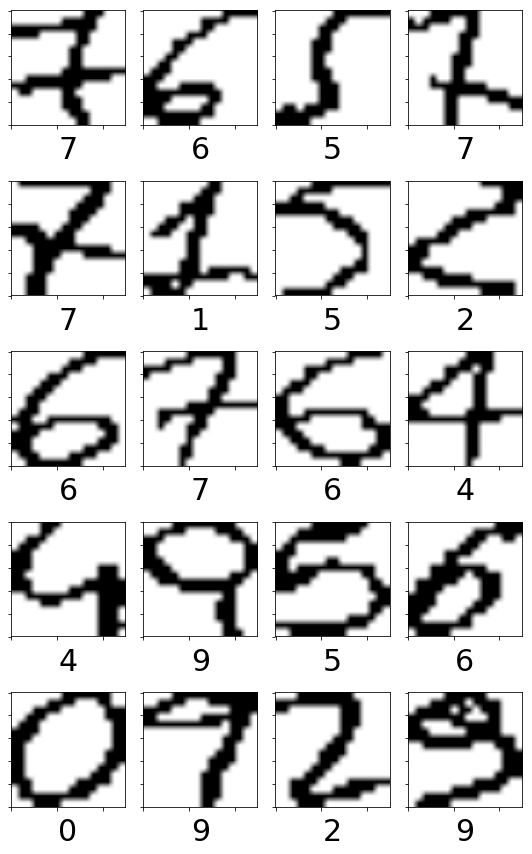

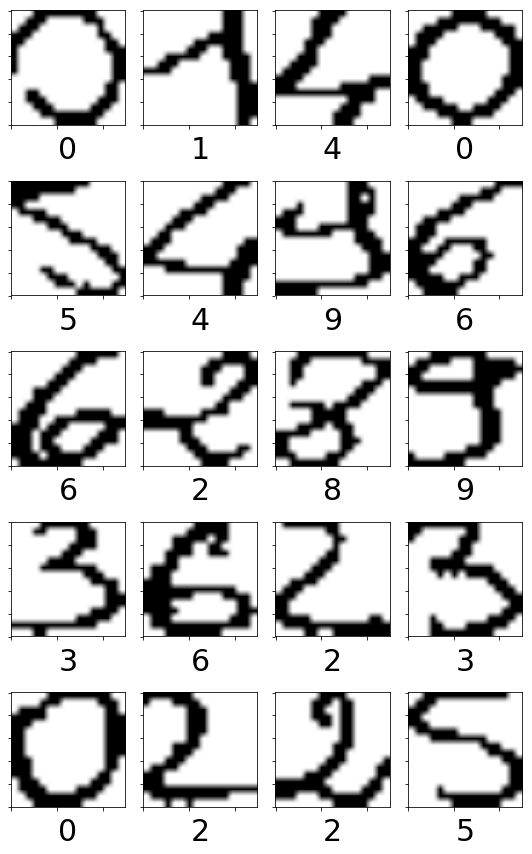

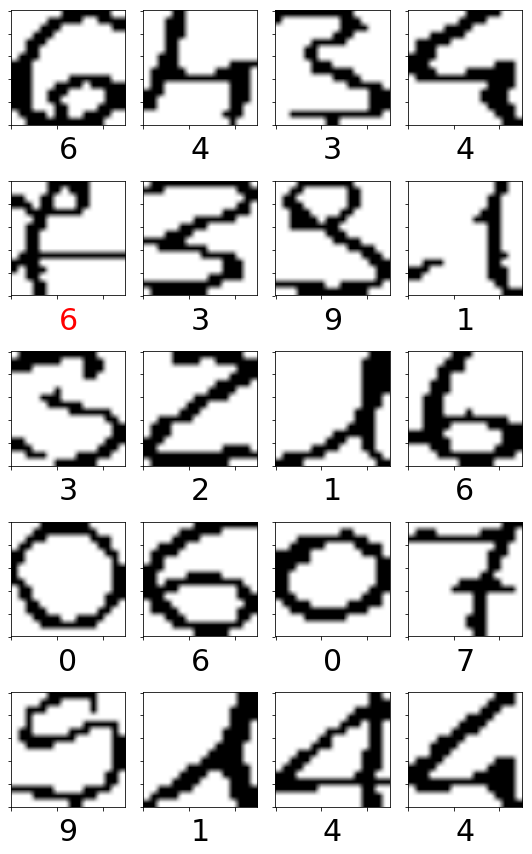

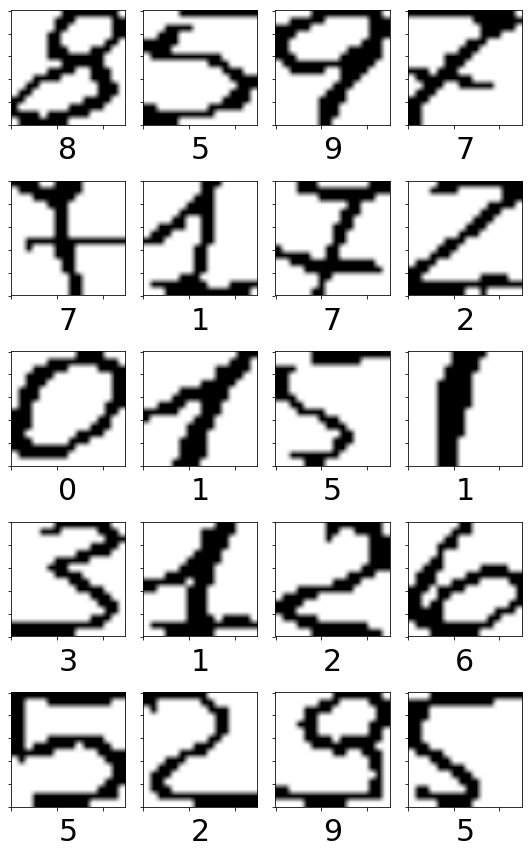

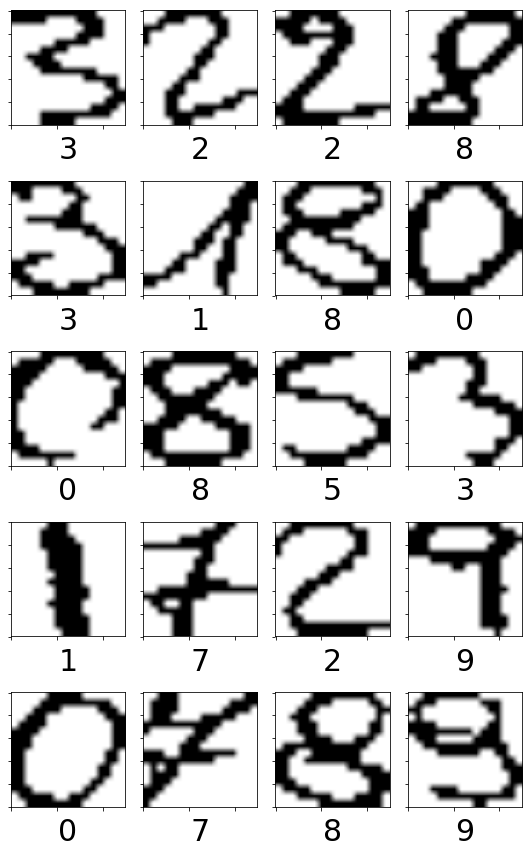

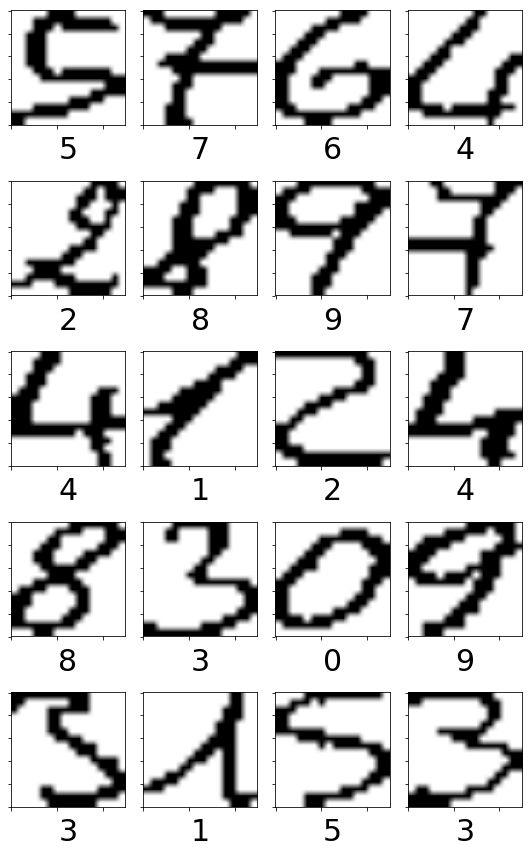

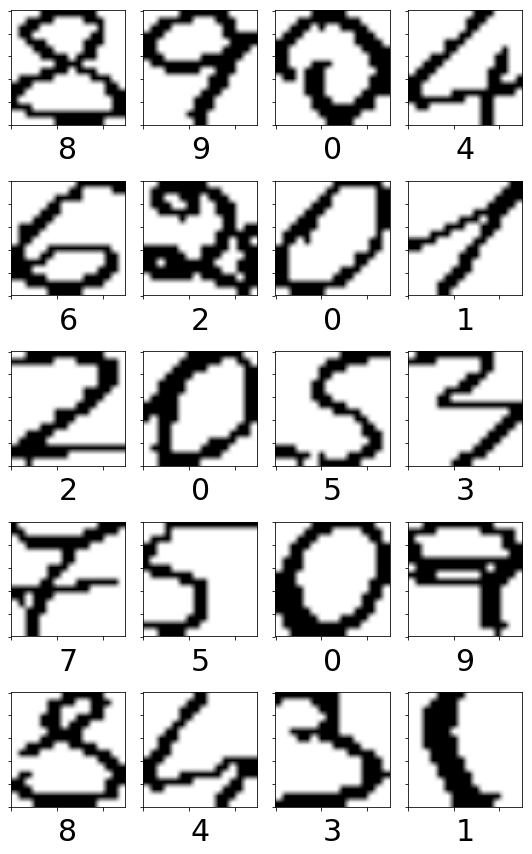

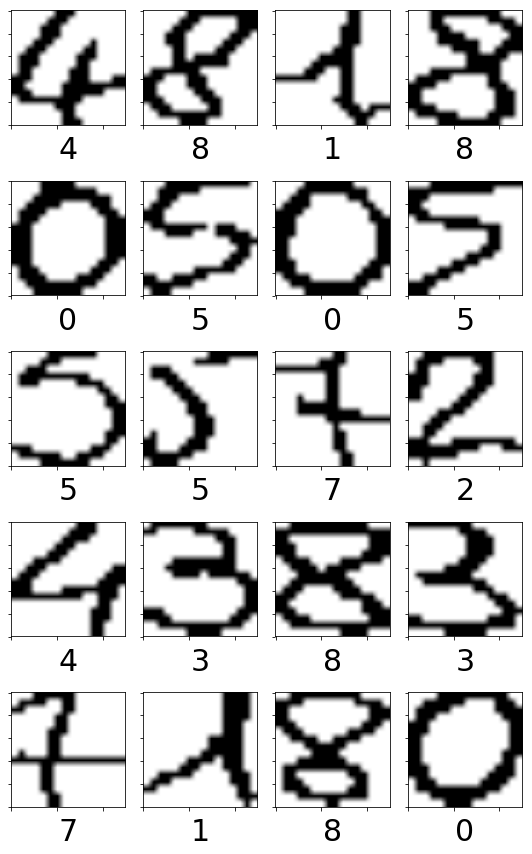

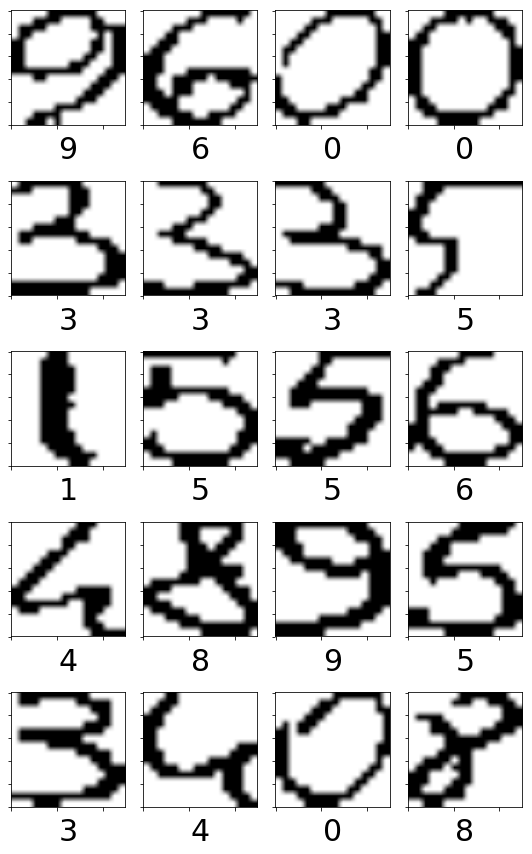

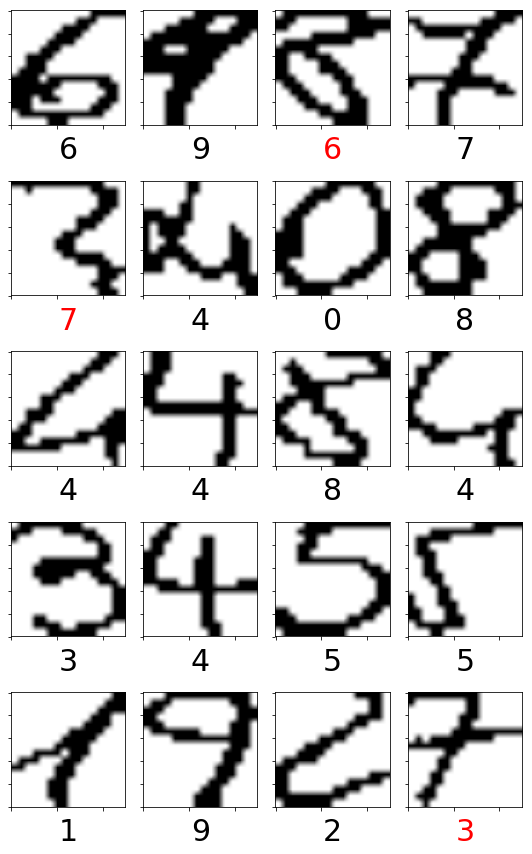

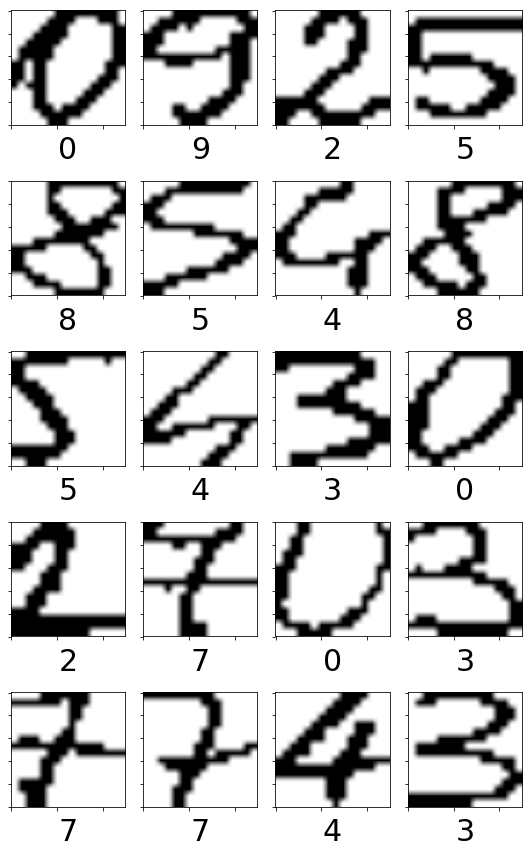

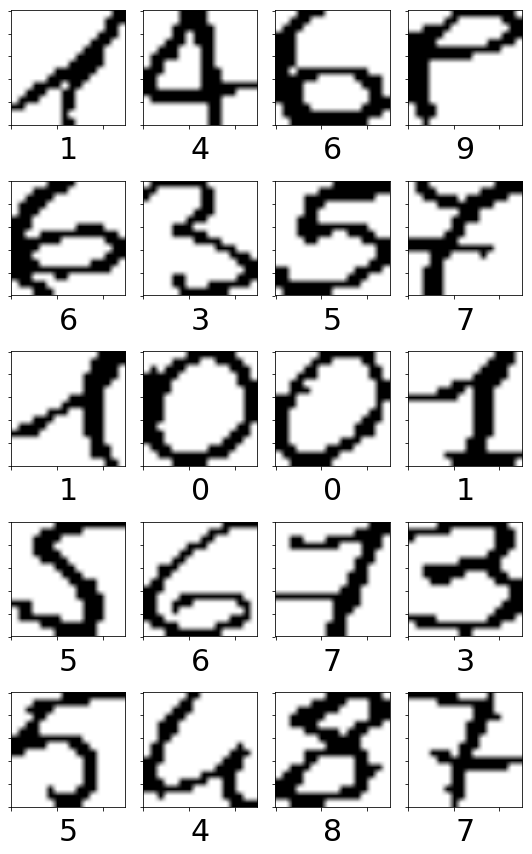

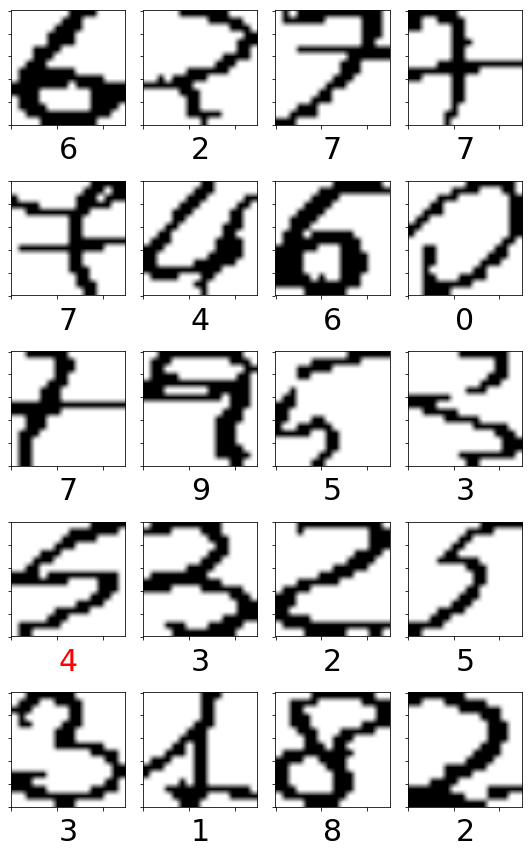

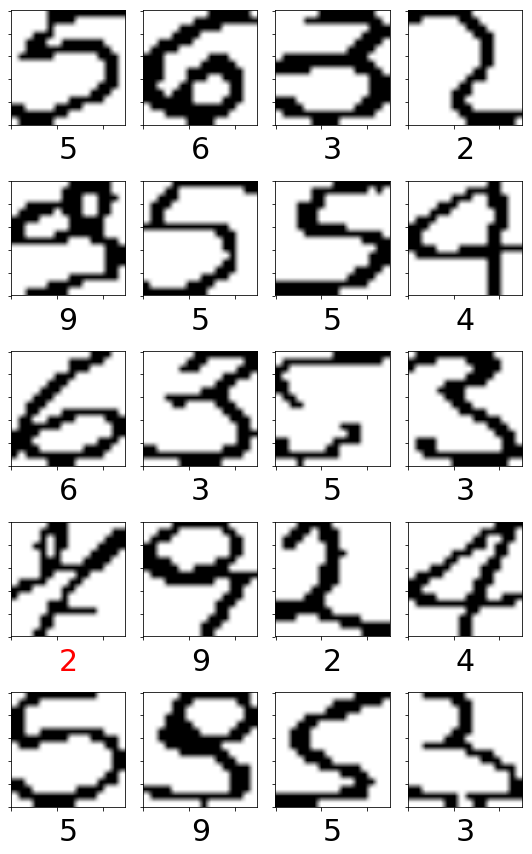

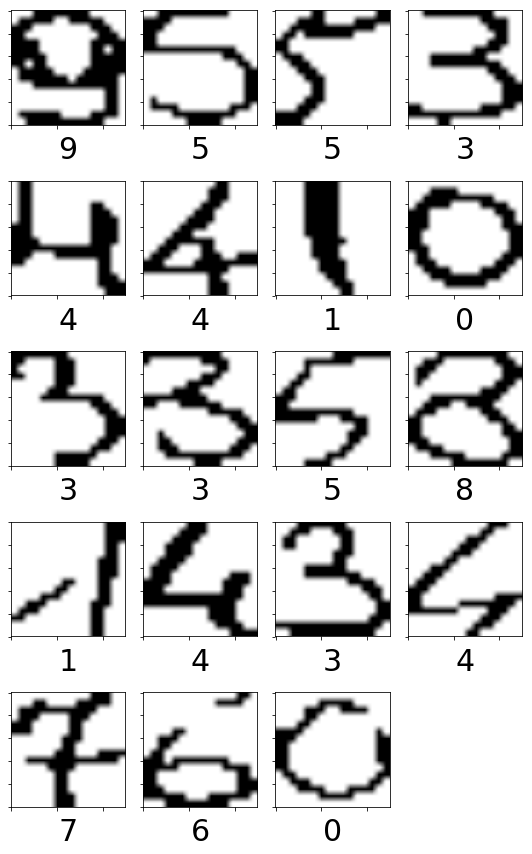

In [31]:
import matplotlib.pyplot as plt

def showFloatImages(image,prediction, real_label):
    
    for i,img3channel in enumerate(image.numpy()):

        img1channel = img3channel[0]
        
        plt.tight_layout( rect=[0.5, 0, 3, 3], h_pad=1)
        
        subplot = plt.subplot(5,4,i+1)

        if prediction[i] == real_label[i]:
            subplot.xaxis.label.set_color('black')
        else:
            subplot.xaxis.label.set_color('red')
            
        subplot.set_xlabel(str(prediction[i])).set_fontsize(30)
        subplot.set_yticklabels([])
        subplot.set_xticklabels([])
        
        plt.imshow(img1channel, cmap='Greys')
        
    
    plt.pause(1)


# Visualize results
for data in testloader:

    images, labels = data

    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    plt.figure(figsize=(3,4))
    showFloatImages(images, predicted, labels)

